- Postgres 11버전부터 지원되는 외부 Extension이다(2.0 버전은 Postgres 9.6 이상).
- 특이한 점이라면 칩 당 천 개 이상의 코어를 지닌 GPU를 활용하여 big data set에 대한 데이터 분석 또는 일괄 처리를 위한 SQL 워크로드를 가속화할 수 있는 점.

**PG-Strom Architecture**

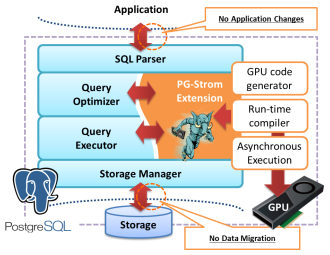

- PG-Strom에서 내세우고 있는 특징은 GPU-Direct SQL로서, 통상적인 RDB가 파일 시스템을 통한 테이블 스캔
- PG-Strom은 이 과정을 GPU에 의존함으로써 수많은 작업에 대한 병렬 처리 등 대용량 데이터에 대한 처리 속도 향상.


**Filesystem을 통한 테이블 스캔과 GPU-Direct SQL을 통한 테이블 스캔의 차이**

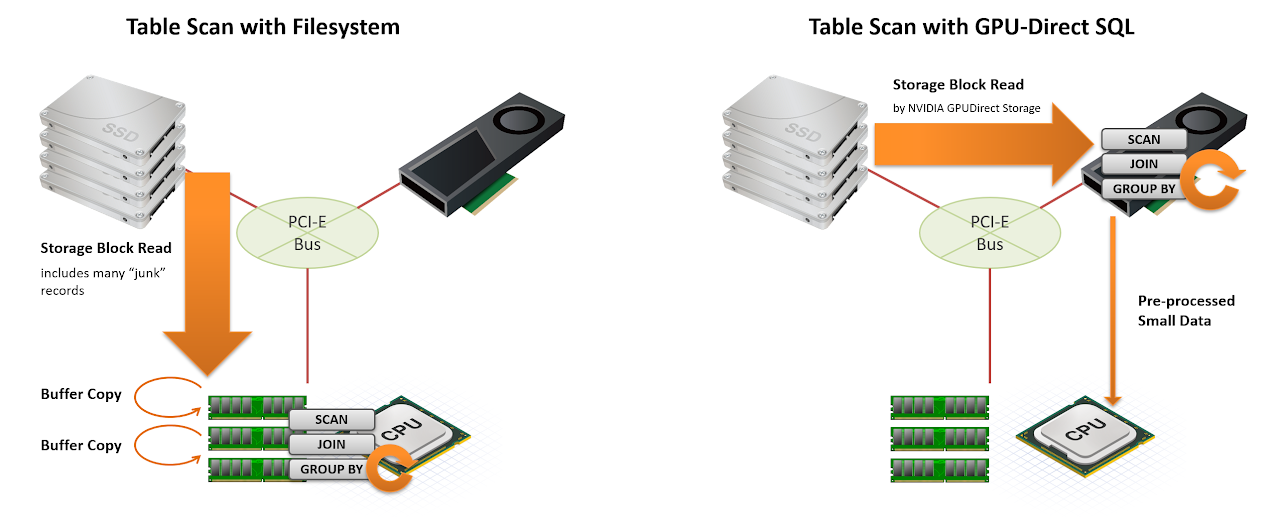

PG-Strom은 다음 두 가지 아이디어를 기반함

- On-the-fly native GPU code 생성
- 비동기 파이프라인 실행 모드


**어떻게 쿼리가 실행 엔진에 submit 되는지, 그리고 쿼리 최적화 단계에서 PG-Storm이 주어진 쿼리가 GPU에서 전체 또는 부분적으로 실행 가능한지 여부를 감지한 다음 쿼리를 전송할 수 있는지 여부를 결정하는 과정**

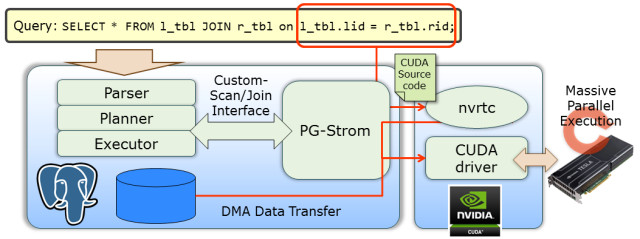

- 전송할 수 있는 쿼리라면, PG-Storm은 실행 단계 전에 실시간 컴파일 프로세스를 시작하여 GPU native binary에 대한 소스 코드를 즉시 생성하고, PG-Storm은 추출된 rowset을 DMA 캐시(버퍼 크기는 기본적으로 15MB)로 불러온 다음 DMA 전송 및 GPU 코어 실행을 비동기식으로 시작.
- CUDA 플랫폼을 사용하면 이러한 작업을 백그라운드에서 실행할 수 있으므로 PostgreSQL이 현재 프로세스를 미리 실행할 수 있다.
- GPU 가속을 통해 이러한 비동기 상관 관계 슬라이스는 일반적인 delay도 숨길 수 있다.

- PG-Strom을 로드한 후 GPU에서 SQL을 실행하기 위한 특별한 지침이 필요하지 않다.
- 이를 통해 사용자는 PostgreSQL 스캔 방식을 사용자 정의할 수 있으며 GPU에서 실행할 수 있는 스캔/조인 로직에 대한 추가 해결 방법을 제공한다.
- 예상 비용이 합리적인 경우 작업 관리자는 기본 제공 쿼리 실행 논리 대신 사용자 지정 스캔 노드를 배치할 수 있다.

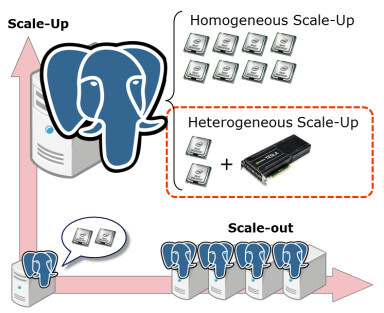

- PG-Strom은 Workload 특성에 대한 H/W 이점을 극대화할 수 있는 heterogeneous longitudinal extension approach(이기종 세로 확장 접근법)를 제공.
- PG-Strom은 CPU Core에서 실행되기 전 GPU 장치에서 간단하고 많은 수의 수치 계산을 할당.


EXPLAIN을 통해 실제 GPU를 사용하는지 확인할 수 있음. 아래는 공식 문서의 예시



```sql
postgres=# EXPLAIN SELECT cat,count(*),avg(ax)
                     FROM t0 NATURAL JOIN t1 NATURAL JOIN t2
                    GROUP BY cat;
                                  QUERY PLAN
--------------------------------------------------------------------------------
 GroupAggregate  (cost=989186.82..989190.94 rows=27 width=20)
   Group Key: t0.cat
   ->  Sort  (cost=989186.82..989187.29 rows=189 width=44)
         Sort Key: t0.cat
         ->  Custom Scan (GpuPreAgg)  (cost=989175.89..989179.67 rows=189 width=44)
               Reduction: Local
               GPU Projection: cat, pgstrom.nrows(), pgstrom.nrows((ax IS NOT NULL)), pgstrom.psum(ax)
               Combined GpuJoin: enabled
               ->  Custom Scan (GpuJoin) on t0  (cost=14744.40..875804.46 rows=99996736 width=12)
                     GPU Projection: t0.cat, t1.ax
                     Outer Scan: t0  (cost=0.00..1833360.36 rows=99996736 width=12)
                     Depth 1: GpuHashJoin  (nrows 99996736...99996736)
                              HashKeys: t0.aid
                              JoinQuals: (t0.aid = t1.aid)
                              KDS-Hash (size: 10.39MB)
                     Depth 2: GpuHashJoin  (nrows 99996736...99996736)
                              HashKeys: t0.bid
                              JoinQuals: (t0.bid = t2.bid)
                              KDS-Hash (size: 10.78MB)
                     ->  Seq Scan on t1  (cost=0.00..1972.85 rows=103785 width=12)
                     ->  Seq Scan on t2  (cost=0.00..1935.00 rows=100000 width=4)
(21 rows)
```

- 가운데 구문의 GPU로부터 직접 개임함을 알 수 있는데, t0, t1, t2의 JOIN Plan에 개입하여 JOIN을 수행하고, GpuJoin의 결과를 받은 GpuPreAgg는 GPU 장치의 cat row에 의해 GROUP BY 연산을 수행.

- PG-Strom은 PostgreSQL이 쿼리 실행 계획을 구축하는 동안 쿼리 최적화 프로그램과 상호 작용하고, SCAN, JOIN 또는 GROUP BY 중 하나라도 GPU 장치에서 실행 가능한 경우 PostgreSQL의 최적화 프로그램에 대한 예상 비용으로 대체 쿼리 실행 계획을 제공.
  - 이 때, 예상 비용은 CPU에서 실행되는 다른 쿼리 실행 계획보다 더 낫고 GPU 장치에서 실행할 대체 실행 계획을 선택하게 된다.



완전히 GPU에 의존하지 않고, CPU+GPU의 하이브리드형 병렬 구조도 가능



```sql
# EXPLAIN SELECT cat,count(*),avg(ax)
            FROM t0 NATURAL JOIN t1
           GROUP by cat;
                                   QUERY PLAN
--------------------------------------------------------------------------------
 GroupAggregate  (cost=955705.47..955720.93 rows=27 width=20)
   Group Key: t0.cat
   ->  Sort  (cost=955705.47..955707.36 rows=756 width=44)
         Sort Key: t0.cat
         ->  Gather  (cost=955589.95..955669.33 rows=756 width=44)
               Workers Planned: 4
               ->  Parallel Custom Scan (GpuPreAgg)  (cost=954589.95..954593.73 rows=189 width=44)
                     Reduction: Local
                     GPU Projection: cat, pgstrom.nrows(), pgstrom.nrows((ax IS NOT NULL)), pgstrom.psum(ax)
                     Combined GpuJoin: enabled
                     ->  Parallel Custom Scan (GpuJoin) on t0  (cost=27682.82..841218.52 rows=99996736 width=12)
                           GPU Projection: t0.cat, t1.ax
                           Outer Scan: t0  (cost=0.00..1083384.84 rows=24999184 width=8)
                           Depth 1: GpuHashJoin  (nrows 24999184...99996736)
                                    HashKeys: t0.aid
                                    JoinQuals: (t0.aid = t1.aid)
                                    KDS-Hash (size: 10.39MB)
                           ->  Seq Scan on t1  (cost=0.00..1972.85 rows=103785 width=12)
(18 rows)
```

- CPU 병렬 실행 모드에서 수집 노드는 여러 백그라운드 작업자 프로세스를 시작한 다음 개별 백그라운드 작업자의 "부분" 실행 결과를 수집.

- GpuJoin 또는 GpuPreAgg와 같이 PG-Strom에서 제공하는 CustomScan 실행 계획은 백그라운드 작업자에서 실행을 지원하여, 이 GPU를 사용하여 부분 작업을 개별적으로 처리.

- CPU 코어는 일반적으로 GPU에서 SQL 워크로드를 실행하는 것보다 GPU에 데이터를 제공하기 위해 버퍼를 설정하는 데 훨씬 더 많은 시간이 필요하므로 CPU와 GPU 병렬의 하이브리드 사용은 더 높은 성능을 기대할 수 있다.

- 반면 각 프로세스는 GPU 통신에 필요한 CUDA 컨텍스트를 생성하고 일정량의 GPU 리소스를 소비하므로 CPU 측의 병렬 처리가 항상 더 좋은 것은 아니므로, 적재적소에 활용하는 지혜가 필요.
- 위의 쿼리 플랜을 보면 Gather 아래의 실행 계획 트리는 백그라운드 작업자 프로세스에서 실행할 수 있음을 알 수 있다.
-  4개의 백그라운드 작업자 프로세스와 코디네이터 프로세스를 사용하여 1억 개의 행을 가진 t0 테이블을 스캔하는데, GpuJoin과 GpuPreAgg에서 프로세스당 2천만 개의 행을 처리하고 그 결과를 Gather 노드에서 병합할 수 있음을 의미.




- PG-Strom은 SCAN, JOIN이나 GROUP BY 워크로드를 GPU에서 수행할 수 있지만, 이러한 사용자 지정 실행 계획이 단순히 PostgreSQL의 표준 작업을 대체하는 경우 최상의 성능으로 작동하지 않는다.(Ex. SCAN이 결과 데이터 세트를 호스트 버퍼에 다시 쓴 다음 동일한 데이터를 다시 GPU로 보내서 JOIN을 실행할 경우, 다시 한 번 JOIN 결과가 다시 기록되고 GROUP BY를 실행하기 위해 GPU로 전송되어 CPU와 GPU 사이에 데이터 핑퐁이 발생함).

- 이러한 비효율적인 작업을 피하기 위해 PG-Strom에는 단일 GPU 커널 호출에서 여러 작업을 실행하는 하위 계획을 가져오는 특수 모드가 있다.
- Operation blow의 조합은 서브플랜의 pull-up을 유발할 수 있다.
  - SCAN + JOIN
  - SCAN + GROUP BY
  - SCAN + JOIN + GROUP BY

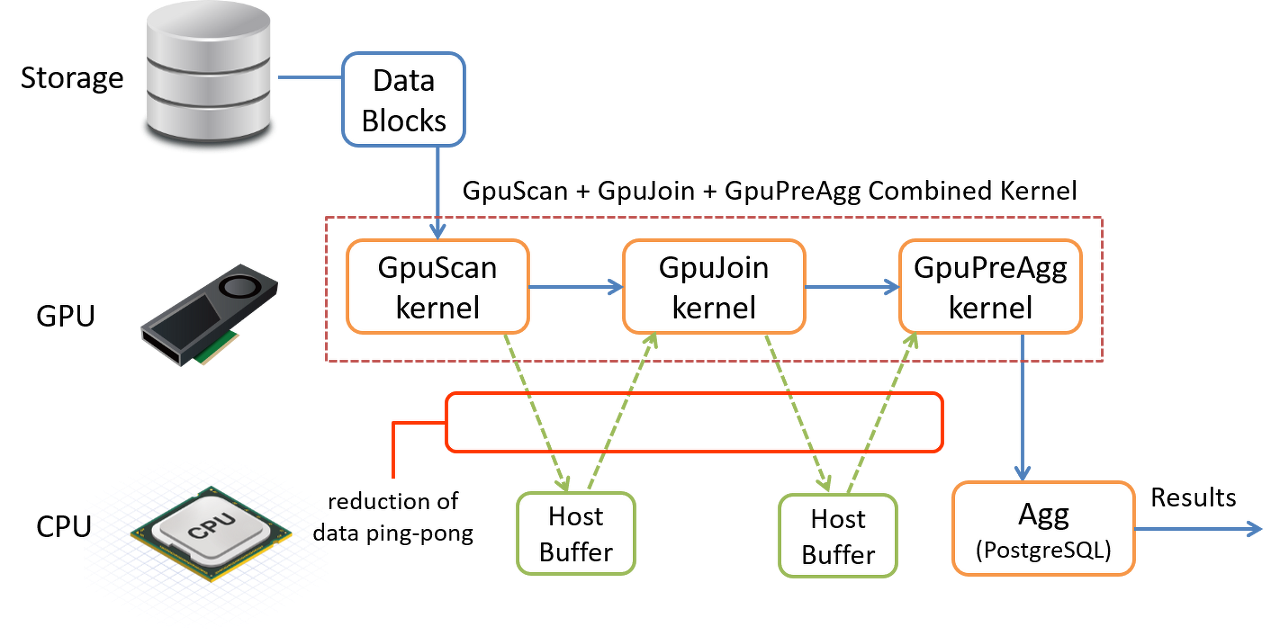

아래의 실행 계획 예시는 서브 플랜을 가져오지 않는다.



```sql
# EXPLAIN SELECT cat,count(*),avg(ax)
            FROM t0 NATURAL JOIN t1
           WHERE aid < bid
           GROUP BY cat;
                              QUERY PLAN

--------------------------------------------------------------------------------
 GroupAggregate  (cost=1239991.03..1239995.15 rows=27 width=20)
   Group Key: t0.cat
   ->  Sort  (cost=1239991.03..1239991.50 rows=189 width=44)
         Sort Key: t0.cat
         ->  Custom Scan (GpuPreAgg)  (cost=1239980.10..1239983.88 rows=189 width=44)
               Reduction: Local
               GPU Projection: cat, pgstrom.nrows(), pgstrom.nrows((ax IS NOT NULL)), pgstrom.psum(ax)
               ->  Custom Scan (GpuJoin)  (cost=50776.43..1199522.96 rows=33332245 width=12)
                     GPU Projection: t0.cat, t1.ax
                     Depth 1: GpuHashJoin  (nrows 33332245...33332245)
                              HashKeys: t0.aid
                              JoinQuals: (t0.aid = t1.aid)
                              KDS-Hash (size: 10.39MB)
                     ->  Custom Scan (GpuScan) on t0  (cost=12634.49..1187710.85 rows=33332245 width=8)
                           GPU Projection: cat, aid
                           GPU Filter: (aid < bid)
                     ->  Seq Scan on t1  (cost=0.00..1972.85 rows=103785 width=12)
(18 rows)
```

- 위 예시는 각 실행 단계에 대해 GPU와 호스트 버퍼 간의 핑퐁을 유발하여 효과적이지 않고 좋은 퍼포먼스를 낼 수 없다.


아래의 쿼리 실행 플랜이 서브 플랜을 가져오게 되어버린다.


```sql
# EXPLAIN ANALYZE SELECT cat,count(*),avg(ax)
                    FROM t0 NATURAL JOIN t1
                   WHERE aid < bid
                   GROUP BY cat;
                              QUERY PLAN
--------------------------------------------------------------------------------
 GroupAggregate  (cost=903669.50..903673.62 rows=27 width=20)
                 (actual time=7761.630..7761.644 rows=27 loops=1)
   Group Key: t0.cat
   ->  Sort  (cost=903669.50..903669.97 rows=189 width=44)
             (actual time=7761.621..7761.626 rows=27 loops=1)
         Sort Key: t0.cat
         Sort Method: quicksort  Memory: 28kB
         ->  Custom Scan (GpuPreAgg)  (cost=903658.57..903662.35 rows=189 width=44)
                                      (actual time=7761.531..7761.540 rows=27 loops=1)
               Reduction: Local
               GPU Projection: cat, pgstrom.nrows(), pgstrom.nrows((ax IS NOT NULL)), pgstrom.psum(ax)
               Combined GpuJoin: enabled
               ->  Custom Scan (GpuJoin) on t0  (cost=12483.41..863201.43 rows=33332245 width=12)
                                                (never executed)
                     GPU Projection: t0.cat, t1.ax
                     Outer Scan: t0  (cost=12634.49..1187710.85 rows=33332245 width=8)
                                     (actual time=59.623..5557.052 rows=100000000 loops=1)
                     Outer Scan Filter: (aid < bid)
                     Rows Removed by Outer Scan Filter: 50002874
                     Depth 1: GpuHashJoin  (plan nrows: 33332245...33332245, actual nrows: 49997126...49997126)
                              HashKeys: t0.aid
                              JoinQuals: (t0.aid = t1.aid)
                              KDS-Hash (size plan: 10.39MB, exec: 64.00MB)
                     ->  Seq Scan on t1  (cost=0.00..1972.85 rows=103785 width=12)
                                         (actual time=0.013..15.303 rows=100000 loops=1)
 Planning time: 0.506 ms
 Execution time: 8495.391 ms
(21 rows)
```

- 위 플랜을 보면, 테이블 t0의 SCAN이 GpuJoin에 내장되고 GpuScan이 사라지는 것을 볼 수 있다.
- 이는 GpuJoin이 기본 GpuScan을 pull-up 한 다음 결합된 GPU 커널 기능이 제공된 WHERE-절의 평가도 담당한다는 걸 알 수 있다.또한 EXPLAIN ANALYZE 결과도 뭔가 이상한데, GpuJoin에 대해 표시되나 실행되지는 않았다.
- 즉, 쿼리 실행 중에는 GpuJoin이 절대 실행되지 않는다는 뜻.
- GpuPreAgg는 기본 GpuJoin을 풀업한 다음 결합된 GPU 커널 기능이 JOIN 및 GROUP BY를 실행.
- pg_strom.pullup_outer_scan 매개변수는 SCAN 풀업 여부를 제어하고 pg_strom.pullup_outer_join 매개변수도 JOIN 풀업 여부를 제어하고, 두 매개변수 모두 on으로 구성.
- 일반적으로 비활성화할 필요는 없지만 매개변수를 사용하여 시스템 문제에 대한 문제를 식별할 수 있다.


